In [1]:
%cd /content/drive/MyDrive/NhanDienBienSoXeMay/code/XacDinhBienSoXeMay/yolov7
!pip install -r requirements.txt

/content/drive/MyDrive/NhanDienBienSoXeMay/code/XacDinhBienSoXeMay/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.4 MB/s eta 0:00:00


In [2]:
import os
import sys
sys.path.append('/content/drive/MyDrive/NhanDienBienSoXeMay/code/XacDinhBienSoXeMay/yolov7')


import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random
from sklearn.svm import SVC

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

from google.colab.patches import cv2_imshow
from keras.models import load_model
from joblib import dump, load

In [3]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [4]:
def crop_sample(img, list_point, sample_size=(30, 60)):
  sample = []
  for point in list_point:
    area = cv2.resize(img[point[1]:point[3], point[0]:point[2]],sample_size, interpolation=cv2.INTER_AREA)
    exchange_range = cv2.bitwise_not(area)
    cv2_imshow(exchange_range)
    sample.append(exchange_range)
  return sample

In [5]:
def reoder_sample(list_point, list_center_y):
  thres = sum(list_center_y) // len(list_center_y)
  list_top_row = []
  list_down_row = []

  for point in list_point:
    if (point[1] + point[3]) // 2 < thres:
      list_top_row.append(point)
    else:
      list_down_row.append(point)

  list_point = sorted(list_top_row, key=lambda x:x[0]) + sorted(list_down_row, key=lambda x:x[0])
  return list_point

In [6]:
def image_processing(img, sample_size=(60, 30)):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=cv2.BORDER_DEFAULT)
  ret, thres = cv2.threshold(blur, 185, 255, cv2.THRESH_BINARY)
  contours, hierarchies = cv2.findContours(thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cv2_imshow(thres)
  # sample = []
  list_point = []
  list_center_y = []
  for ct in contours:
    # cv2_imshow(thres[min(ct[:][1]):max(ct[:][1]), min(ct[:][0]):max(ct[:][0])])
    # print( min(ct[:][1]), max(ct[:][1]), min(ct[:][0]), max(ct[:][0]) )
    min_x, min_y, max_x, max_y = thres.shape[1], thres.shape[0], 0, 0
    for point in ct:
      min_x = min(min_x, point[0][0])
      min_y = min(min_y, point[0][1])
      max_x = max(max_x, point[0][0])
      max_y = max(max_y, point[0][1])
    # print(min_x, min_y, max_x, max_y)
    acspect = ((max_x - min_x) * (max_y - min_y)) / (thres.shape[1] * thres.shape[0])
    if acspect >= 0.025 and acspect <= 0.08 and (max_x - min_x) < (max_y - min_y):
      # area = cv2.resize(thres[min_y:max_y, min_x:max_x],(30,60), interpolation=cv2.INTER_AREA)
      # exchange_range = cv2.bitwise_not(area)
      # cv2_imshow(exchange_range)
      # sample.append(exchange_range)
      list_point.append((min_x, min_y, max_x, max_y))
      list_center_y.append((min_y + max_y) // 2)

  reoder_list = reoder_sample(list_point, list_center_y)
  return crop_sample(thres, reoder_list, sample_size)

In [7]:
def classification(sample):
  
  label_dict_ex = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 
                   7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 
                   14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L', 
                   20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 
                   26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}
  model = load_model("/content/drive/MyDrive/NhanDienBienSoXeMay/code/DigitalClassificationModel/15_epochs_model2.h5")
  
  sample = np.array(sample, "float")
  sample = sample.reshape(sample.shape[0], sample.shape[1], sample.shape[2], 1) / 255

  results = model.predict(sample)
  label = []
  for result in results:
    label.append(label_dict_ex[np.argmax(result)])
    print(label_dict_ex[np.argmax(result)], result[np.argmax(result)]*100)

  if len(label) == 9:
    label.insert(-2,".")
    
  label.insert(2,"-")
  label.insert(5," ")
  return label

In [13]:
def classification2(sample):
  
  label_dict_ex = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 
                   7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 
                   14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L', 
                   20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 
                   26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}
  SVM = load("/content/drive/MyDrive/NhanDienBienSoXeMay/code/DigitalClassificationModel/SVM3.joblib")
  
  sample = np.array(sample, np.uint8)
  sample = sample.reshape(sample.shape[0], -1)

  results = SVM.predict(sample)
  label = []
  for result in results:
    label.append(label_dict_ex[result])
  print(np.max(SVM.predict_proba(sample), axis=(1))*100)
  print(np.argmax(SVM.predict_proba(sample), axis=(1)))
  print(SVM.predict_proba(sample))

  if len(label) == 9:
    label.insert(-2,".")
    
  label.insert(2,"-")
  label.insert(5," ")
  return label

In [9]:
def char_digital_classification(img, xyxy, sample_size=(60,30), model_mode="CNN"):

  # extract top-left point anh bottom-right point
  pt1 = (int(xyxy[0].item()),int(xyxy[1].item()))
  pt2 = (int(xyxy[2].item()),int(xyxy[3].item()))
  # cropping plate's area
  img_cropped = img[pt1[1]:pt2[1], pt1[0]:pt2[0]]

  cv2_imshow(img_cropped)
  # image processing and cropping digital charater
  sample = image_processing(img_cropped, sample_size)
  # classification image
  if model_mode == 0 or model_mode == "CNN":
    return classification(sample)
  if model_mode == 1 or model_mode == "SVM":
    return classification2(sample)

In [10]:
def detect_plate(opt, source_image_path, sample_size=(60,30), model_mode="CNN"):
  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
      model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    img0 = cv2.imread(source_image_path)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment= False)[0]

    # Apply NMS
    classes = None
    if opt['classes']:
      classes = []
      for class_name in opt['classes']:

        classes.append(opt['classes'].index(class_name))


    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
      
        for *xyxy, conf, cls in reversed(det):
          
          res = char_digital_classification(img0, xyxy, sample_size, model_mode=model_mode)
          # label = f'{names[int(cls)]} {conf:.2f}'
          label = ("").join(res)
          plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)
          
  return cv2.resize(img0,(640, 640), interpolation=cv2.INTER_AREA)

In [ ]:
%cd "/content/drive/MyDrive/NhanDienBienSoXeMay/data/PersonalTest"
!wget -P "/content/drive/MyDrive/NhanDienBienSoXeMay/data/PersonalTest" -O test4.jpg https://csgt.com.vn/wp-content/uploads/2022/07/Co-duoc-gan-bien-so-xe-may-o-phia-truoc-xe-hay-khong-2.jpg

/content/drive/MyDrive/NhanDienBienSoXeMay/data/PersonalTest
--2023-02-20 17:48:32--  https://csgt.com.vn/wp-content/uploads/2022/07/Co-duoc-gan-bien-so-xe-may-o-phia-truoc-xe-hay-khong-2.jpg
Resolving csgt.com.vn (csgt.com.vn)... 104.21.5.136, 172.67.133.127, 2606:4700:3030::ac43:857f, ...
Connecting to csgt.com.vn (csgt.com.vn)|104.21.5.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Could not parse String-Transport-Security header
Length: 98547 (96K) [image/jpeg]
Saving to: ‘test4.jpg’

                    100%[===================>]  96.24K  --.-KB/s    in 0.004s  

2023-02-20 17:48:32 (22.5 MB/s) - ‘test4.jpg’ saved [98547/98547]



/content/drive/MyDrive/NhanDienBienSoXeMay/code/XacDinhBienSoXeMay/yolov7
Fusing layers... 
IDetect.fuse


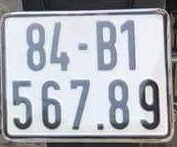

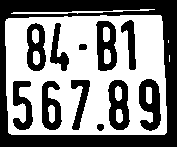

[     88.188      86.894      50.168      86.896      94.533      92.854      72.588      80.161      87.467]
[ 8  4 11  1  5  6  7  8  9]
[[  0.0079338  0.00091986   0.0012294   0.0018284  0.00095184    0.002032   0.0048891  0.00082438     0.88188   0.0075982   0.0010759    0.039754   0.0014741   0.0042269   0.0018683   0.0011873   0.0022921   0.0053453    0.001222  0.00086894   0.0032855   0.0042943   0.0021134   0.0096561   0.0019295  0.00073839
    0.0045804   0.0013052  0.00081753  0.00078085   0.0011019]
 [  0.0041284   0.0085463   0.0042888   0.0020623     0.86894   0.0044476   0.0072678   0.0014761   0.0023558   0.0042752   0.0068672   0.0050402   0.0074285   0.0039977   0.0074288   0.0032453   0.0017266   0.0034924    0.016043   0.0045081   0.0043188   0.0054639   0.0029974   0.0027661   0.0021954   0.0015616
    0.0020023   0.0023158   0.0045185   0.0016583   0.0026331]
 [    0.01797   0.0016616   0.0025193   0.0030225   0.0017574    0.004576   0.0099824   0.0013229       0.3

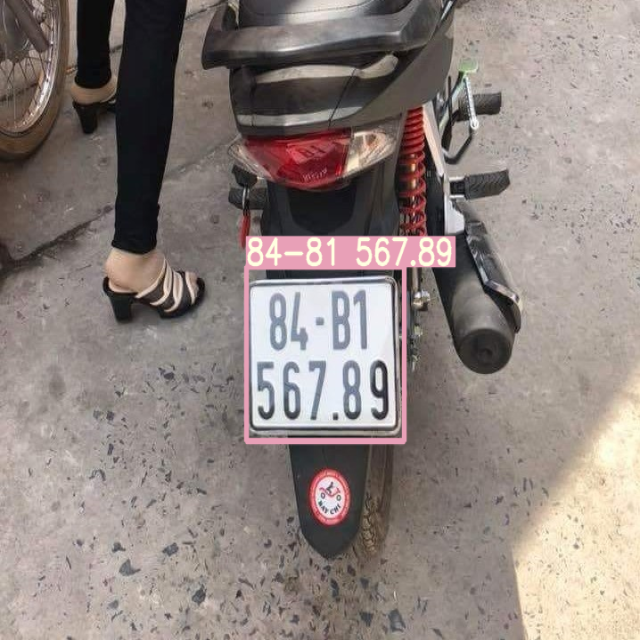

In [16]:
if __name__ == "__main__":
  %cd /content/drive/MyDrive/NhanDienBienSoXeMay/code/XacDinhBienSoXeMay/yolov7
  classes_to_filter = None  #You can give list of classes to filter by name, Be happy you don't have to put class number. ['train','person' ]
  source_image_path = "/content/drive/MyDrive/NhanDienBienSoXeMay/data/PersonalTest/test4.jpg"

  opt  = {
    
    "weights": "/content/drive/MyDrive/NhanDienBienSoXeMay/code/XacDinhBienSoXeMay/yolov7/runs/train/exp14/weights/best.pt", # Path to weights file default weights are for nano model
    "yaml"   : "/content/drive/MyDrive/NhanDienBienSoXeMay/code/XacDinhBienSoXeMay/yolov7/data/mydataset.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.7, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : '0',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None
        }
  sample_size = (12,28)
  img_result = detect_plate(opt, source_image_path, sample_size, model_mode="SVM")
  cv2_imshow(img_result)

**Lưu ý**

- Tìm hướng xử lý hình ảnh mới
- Mô hình dự đoán ký tự quá kém, có thể do chất lượng dataset thấp